## Boosted Information Trees (Python3) Demo

In [1]:
import numpy as np
import random
import cProfile
import time
import matplotlib.pyplot as plt

from BoostedInformationTreeP3 import BoostedInformationTree


### Toy Power Law Model

In [2]:
data_dir = 'data'

training_features = np.loadtxt('%s/training_features_power_law_model.txt.gz' % data_dir)
training_features = training_features.reshape(training_features.shape[0], -1)
training_weights = np.loadtxt('%s/training_weights_power_law_model.txt.gz' % data_dir)
training_diff_weights = np.loadtxt('%s/training_diff_weights_power_law_model.txt.gz' % data_dir)

test_features = np.loadtxt('%s/test_features_power_law_model.txt.gz' % data_dir)
test_features = training_features.reshape(training_features.shape[0], -1)
test_weights = np.loadtxt('%s/test_weights_power_law_model.txt.gz' % data_dir)
test_diff_weights = np.loadtxt('%s/test_diff_weights_power_law_model.txt.gz' % data_dir)

In [3]:
xmin  = 20
xmax  = 420 
alpha = 3
pT0   = 100

def power_law_model(x):
    return x**(-alpha)

def theoretical_power_law_model_score(x):
    return 1/(alpha - 1) - np.log(x/pT0)

min_score_theory = min(theoretical_power_law_model_score(xmin), theoretical_power_law_model_score(xmax))
max_score_theory = max(theoretical_power_law_model_score(xmin), theoretical_power_law_model_score(xmax))

### Training

In [4]:
n_trees       = 100
learning_rate = 0.2 
max_depth     = 2
min_size      = 50

bit = BoostedInformationTree(
        training_features = training_features,
        training_weights      = training_weights, 
        training_diff_weights = training_diff_weights, 
        learning_rate = learning_rate, 
        n_trees = n_trees,
        max_depth=max_depth,
        min_size=min_size,
        split_method='vectorized_split_and_weight_sums',
        weights_update_method='vectorized')

bit.boost()


[                    --------------------]
weak learner time: 9.73
update time: 0.20


In [5]:
x_grid = np.linspace(xmin, xmax, 500)
theoretical_scores = theoretical_power_law_model_score(x_grid)
predicted_scores = np.array([bit.predict([feature], vectorized=False) for feature in x_grid])

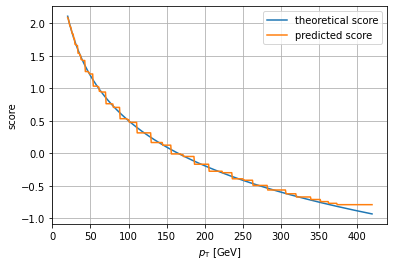

In [6]:
plt.plot(x_grid, theoretical_scores, label="theoretical score")
plt.plot(x_grid, predicted_scores, label="predicted score")
plt.xlabel("$p_{\mathrm{T}}$ [GeV]")
plt.ylabel("score")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()

In [7]:
time1 = time.time()
predicted_scores_training = bit.predict(training_features, summed=False)
predicted_scores_test = bit.predict(test_features, summed=False)
time2 = time.time()
print("prediction time for %d events: %.2f seconds" % (len(training_features), time2 - time1))
predicted_scores_training.shape

prediction time for 100000 events: 0.41 seconds


(100, 100000)

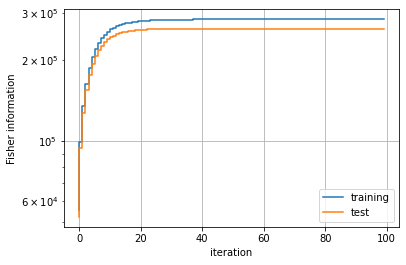

Final test FI: 261567.802994
Final overfitting gap: 8.63 %


In [8]:
fisher_information_evolution_training = np.dot(np.cumsum(predicted_scores_training, axis=0), training_diff_weights)
fisher_information_evolution_test = np.dot(np.cumsum(predicted_scores_test, axis=0), test_diff_weights)

plt.step(list(range(n_trees)), fisher_information_evolution_training, label='training')
plt.step(list(range(n_trees)), fisher_information_evolution_test, label='test')
plt.grid(True)
plt.xlabel("iteration")
plt.ylabel("Fisher information")
plt.yscale('log')
plt.legend(loc="lower right")
plt.show()

print("Final test FI: %2f" % fisher_information_evolution_test[-1])
print("Final overfitting gap: %.2f %%" % ((fisher_information_evolution_training[-1]/fisher_information_evolution_test[-1] - 1)*100))